## Notebook for plotting the connectivity matrices

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch

from bindsnet.network import Network
from bindsnet.network.nodes import Input, AdaptiveLIFNodes
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor
from bindsnet.network.nodes import Input, LIFNodes
from bindsnet.learning import PostPre

from utils import draw_weights



In [12]:
def plot_connectivity(weights, title=None):

    w = weights.detach().clone().cpu().numpy().T

    fig, ax = plt.subplots(figsize=(5,5))

    abs_max = np.amax(np.absolute(w))
    im = plt.imshow(w, cmap='bwr', vmin=-abs_max, vmax=abs_max)
    fig.colorbar(im, fraction=0.046, pad=0.04, ticks=[np.amin(w), 0, np.amax(w)])
    
    ax.set_xlabel("Post")
    ax.set_ylabel("Pre") 
    ax.invert_yaxis()

    plt.title(title, pad=20)

    fig.tight_layout()
    plt.show()

In [4]:
def poisson_input(
    T, n_neurons, dt,
    target_idx,
    target_rate,
    bg_rate,
    batch_size=1
):
    """
    Generate Poisson spike trains in numpy.

    Args:
        T             : number of time steps
        n_neurons     : number of neurons
        dt            : timestep (ms)
        target_idx    : list of target neuron indices
        target_rate   : firing rate for target neurons (Hz)
        bg_rate       : firing rate for all other neurons (Hz)
        batch_size    : number of batches

    Returns:
        spikes : NumPy array [T, batch_size, n_neurons] of 0/1
    """
    # baseline rates
    rates = np.full(n_neurons, bg_rate, dtype=np.float32)
    rates[np.array(target_idx, dtype=int)] = target_rate

    # probability per step
    p = rates * (dt / 1000.0)  # Hz × s
    p = np.clip(p, 0.0, 1.0)

    # sample
    rand = np.random.rand(T, batch_size, n_neurons)
    spikes = (rand < p).astype(np.float32)
    
    return spikes

In [5]:
# Params
n_inputs   = 100
n_neurons  = 100
dt         = 1.0
sim_length = 400
T          = int(sim_length / dt)

# Stimulate a group of neurons
target_idx  = np.arange(10)
target_rate = 30.0
bg_rate     = 2.0

    
I_ext = np.arange(0, sim_length, dt) * 0
I_ext[100:300] = 250

poisson_spikes = poisson_input(T, n_neurons, dt, target_idx, target_rate, bg_rate)
print(poisson_spikes.shape)


I_ext = torch.from_numpy(poisson_spikes)  


(400, 1, 100)


In [6]:
# connections

def connect_one_to_one(n_pre, n_post):
    """
    1 on the main diagonal (i -> i), 0 elsewhere.
    Extra rows/cols stay 0 if sizes differ.
    """
    A = np.zeros((n_pre, n_post), dtype=np.float32)
    np.fill_diagonal(A, 1)
    return A


def connect_all_to_all(n_pre, n_post, exclude_self=True):
    """
    All ones. If square and exclude_self=True, zero the diagonal.
    """
    A = np.ones((n_pre, n_post), dtype=np.float32)
    if exclude_self and n_pre == n_post:
        np.fill_diagonal(A, 0)
    return A

def connect_random(n_pre, n_post, p=0.1, exclude_self=True):
    """
    Each edge present with prob p (independent).
    """
    A = (np.random.rand(n_pre, n_post) < p).astype(np.float32)
    if exclude_self and n_pre == n_post:
        np.fill_diagonal(A, 0)
    return A

## 1:1 

In [14]:
# vars
n_inpt = 784
inpt_shape = (1, 28, 28)
n_neurons = 100
exc = 22.5
inh = 17.5
dt = 1.0
nu = (1e-4, 1e-2)
reduction = None
wmin = 0.0
wmax = 1.0
norm = 78.4
theta_plus = 0.05
tc_theta_decay = 1e7
inpt_shape = None
inh_thresh = -40.0
exc_thresh = -52.0
time = 50


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on Device = ", device)



# Layers
input_layer = Input(
    n=n_inpt, shape=inpt_shape, traces=True, tc_trace=20.0
)

exc_layer = LIFNodes(
    n=n_neurons,
    traces=True,
    rest=-65.0,
    reset=-60.0,
    thresh=exc_thresh,
    refrac=5,
    tc_decay=100.0,
    tc_trace=20.0,
    theta_plus=theta_plus,
    tc_theta_decay=tc_theta_decay,
)

inh_layer = LIFNodes(
    n=n_neurons,
    traces=False,
    rest=-60.0,
    reset=-45.0,
    thresh=inh_thresh,
    tc_decay=10.0,
    refrac=2,
    tc_trace=20.0,
)

# Connections
# I -> Ex
connections = connect_all_to_all(n_inpt, n_neurons)
weights     = np.random.rand(n_inpt, n_neurons).astype(np.float32)  
w           = 0.3 * torch.from_numpy(connections * weights)
input_exc_conn = Connection(
    source=input_layer,
    target=exc_layer,
    w=w,
    update_rule=PostPre, # stdp
    nu=nu,
    reduction=reduction,
    wmin=wmin,
    wmax=wmax,
    norm=norm,
)

# Ex -> Inh
connections = connect_one_to_one(n_neurons, n_neurons)
weights     = np.random.rand(n_neurons, n_neurons).astype(np.float32)  
w           = exc * torch.from_numpy(connections * weights)
exc_inh_conn = Connection(
    source=exc_layer, target=inh_layer, w=w, wmin=0, wmax=exc
)

# Inh -> Ex
connections = connect_one_to_one(n_neurons, n_neurons)
weights     = np.random.rand(n_neurons, n_neurons).astype(np.float32)  
w           = -inh * torch.from_numpy(connections * weights)
inh_exc_conn = Connection(
    source=inh_layer, target=exc_layer, w=w, wmin=-inh, wmax=0
)

# Add to network
net = Network()

net.add_layer(input_layer, name="X")
net.add_layer(exc_layer, name="Exc")
net.add_layer(inh_layer, name="Inh")
net.add_connection(input_exc_conn, source="X", target="Exc")
net.add_connection(exc_inh_conn, source="Exc", target="Inh")
net.add_connection(inh_exc_conn, source="Inh", target="Exc")


Running on Device =  cuda


In [15]:
net.connections


{('X',
  'Exc'): Connection(
   (source): Input()
   (target): LIFNodes()
 ),
 ('Exc',
  'Inh'): Connection(
   (source): LIFNodes()
   (target): LIFNodes()
 ),
 ('Inh',
  'Exc'): Connection(
   (source): LIFNodes()
   (target): LIFNodes()
 )}

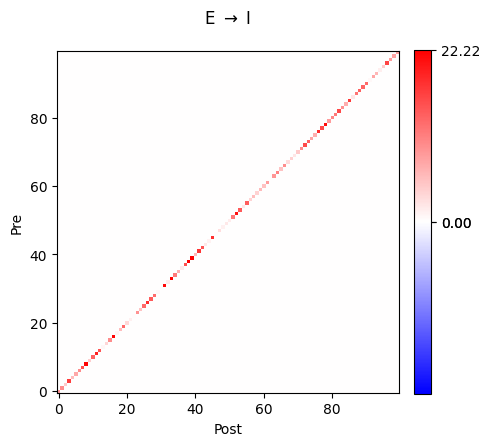

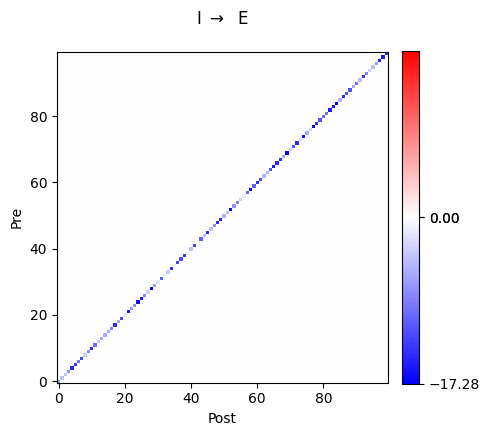

In [13]:
# Run with Poisson spikes into the Input layer 
net.run(inputs={"Input": I_ext}, time=T)

w_exc_inh = net.connections[('Exc','Inh')].w
w_inh_exc = net.connections[('Inh','Exc')].w

plot_connectivity(w_exc_inh,  title=r"E $\rightarrow$ I")
plot_connectivity(w_inh_exc,  title=r"I $\rightarrow$  E")

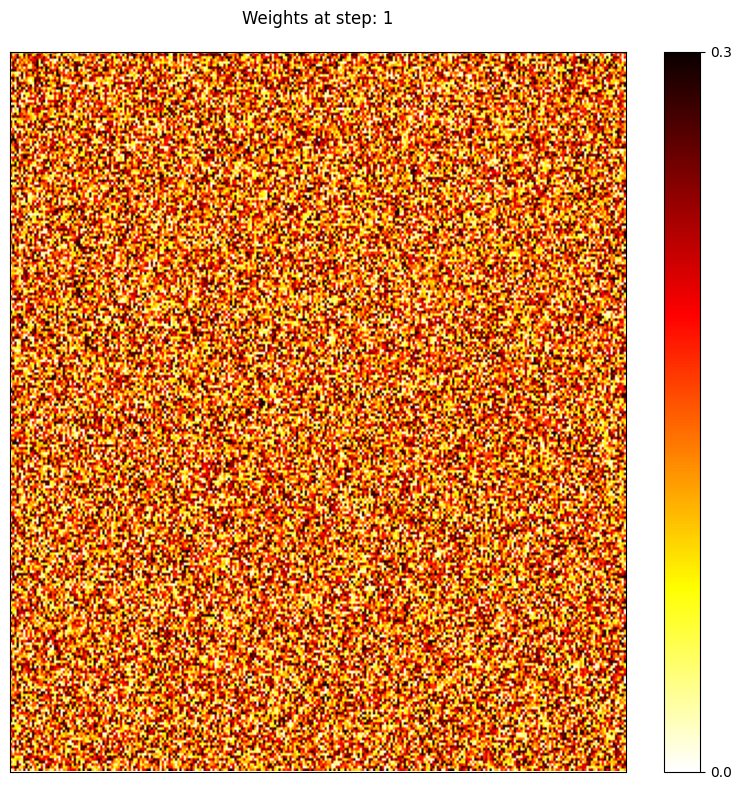

In [16]:
w_x_exc = net.connections[('X', 'Exc')].w

draw_weights(w_x_exc, 1)
#plot_connectivity(w_x_exc,  title="w_x_exc")

## Rand Symmetrical

In [29]:
# vars
n_inpt = 784
inpt_shape = (1, 28, 28)
n_neurons = 100
exc = 22.5
inh = 17.5
dt = 1.0
nu = (1e-4, 1e-2)
reduction = None
wmin = 0.0
wmax = 1.0
norm = 78.4
theta_plus = 0.05
tc_theta_decay = 1e7
inpt_shape = None
inh_thresh = -40.0
exc_thresh = -52.0
time = 50


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on Device = ", device)



# Layers
input_layer = Input(
    n=n_inpt, shape=inpt_shape, traces=True, tc_trace=20.0
)

exc_layer = LIFNodes(
    n=n_neurons,
    traces=True,
    rest=-65.0,
    reset=-60.0,
    thresh=exc_thresh,
    refrac=5,
    tc_decay=100.0,
    tc_trace=20.0,
    theta_plus=theta_plus,
    tc_theta_decay=tc_theta_decay,
)

inh_layer = LIFNodes(
    n=n_neurons,
    traces=False,
    rest=-60.0,
    reset=-45.0,
    thresh=inh_thresh,
    tc_decay=10.0,
    refrac=2,
    tc_trace=20.0,
)

# Connections
# I -> Ex
connections = connect_all_to_all(n_inpt, n_neurons)
weights     = np.random.rand(n_inpt, n_neurons).astype(np.float32)  
w           = exc * torch.from_numpy(connections * weights)
input_exc_conn = Connection(
    source=input_layer,
    target=exc_layer,
    w=w,
    update_rule=PostPre, # stdp
    nu=nu,
    reduction=reduction,
    wmin=wmin,
    wmax=wmax,
    norm=norm,
)

# Ex -> Inh
connections = connect_random(n_neurons, n_neurons)
weights     = np.random.rand(n_neurons, n_neurons).astype(np.float32)  
w           = exc * torch.from_numpy(connections * weights)
exc_inh_conn = Connection(
    source=exc_layer, target=inh_layer, w=w, wmin=0, wmax=exc
)

# Inh -> Ex
#connections = connect_one_to_one(n_neurons, n_neurons)

#weights     = np.random.rand(n_neurons, n_neurons).astype(np.float32)  
w           = -inh * torch.from_numpy(connections * weights)
inh_exc_conn = Connection(
    source=inh_layer, target=exc_layer, w=w, wmin=-inh, wmax=0
)

# Add to network
net = Network()

net.add_layer(input_layer, name="X")
net.add_layer(exc_layer, name="Exc")
net.add_layer(inh_layer, name="Inh")
net.add_connection(input_exc_conn, source="X", target="Exc")
net.add_connection(exc_inh_conn, source="Exc", target="Inh")
net.add_connection(inh_exc_conn, source="Inh", target="Exc")


Running on Device =  cuda


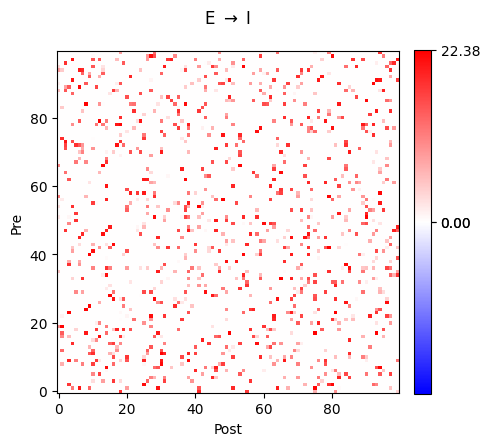

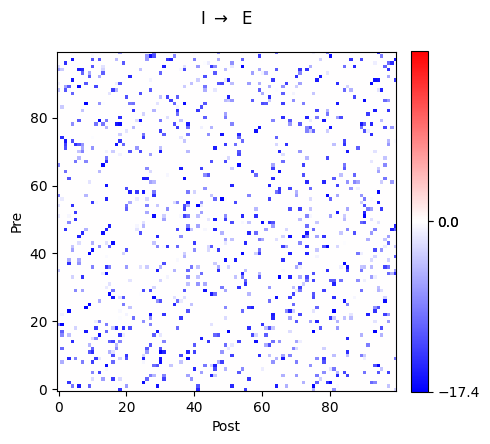

In [30]:
# Run with Poisson spikes into the Input layer 
net.run(inputs={"Input": I_ext}, time=T)

w_exc_inh = net.connections[('Exc','Inh')].w
w_inh_exc = net.connections[('Inh','Exc')].w

plot_connectivity(w_exc_inh,  title=r"E $\rightarrow$ I")
plot_connectivity(w_inh_exc,  title=r"I $\rightarrow$  E")

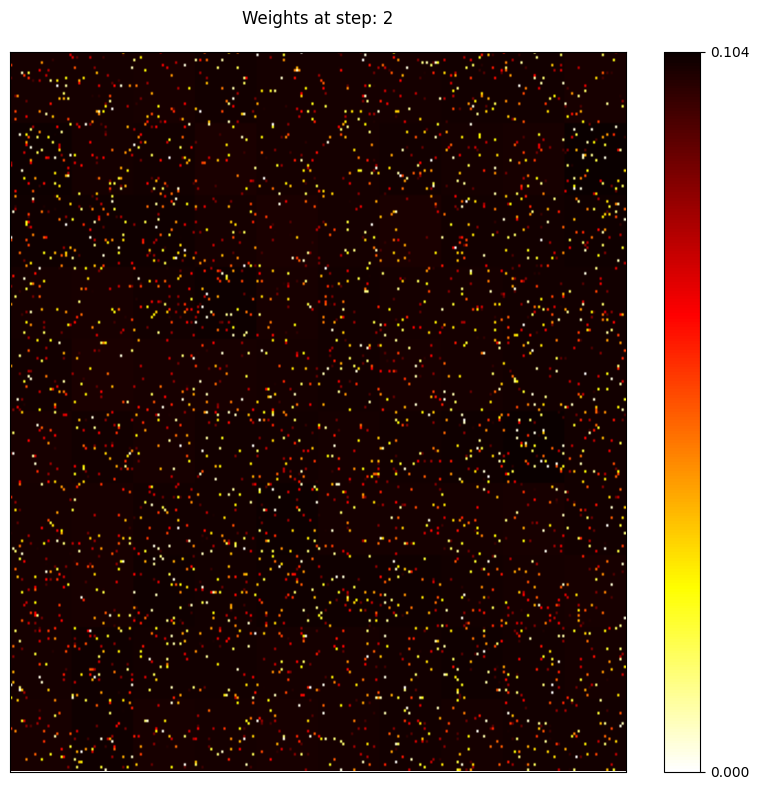

In [ ]:
w_x_exc = net.connections[('X', 'Exc')].w

draw_weights(w_x_exc, 1)
#plot_connectivity(w_x_exc,  title="w_x_exc")

## Random

In [31]:
# vars
n_inpt = 784
inpt_shape = (1, 28, 28)
n_neurons = 100
exc = 22.5
inh = 17.5
dt = 1.0
nu = (1e-4, 1e-2)
reduction = None
wmin = 0.0
wmax = 1.0
norm = 78.4
theta_plus = 0.05
tc_theta_decay = 1e7
inpt_shape = None
inh_thresh = -40.0
exc_thresh = -52.0
time = 50


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on Device = ", device)



# Layers
input_layer = Input(
    n=n_inpt, shape=inpt_shape, traces=True, tc_trace=20.0
)

exc_layer = LIFNodes(
    n=n_neurons,
    traces=True,
    rest=-65.0,
    reset=-60.0,
    thresh=exc_thresh,
    refrac=5,
    tc_decay=100.0,
    tc_trace=20.0,
    theta_plus=theta_plus,
    tc_theta_decay=tc_theta_decay,
)

inh_layer = LIFNodes(
    n=n_neurons,
    traces=False,
    rest=-60.0,
    reset=-45.0,
    thresh=inh_thresh,
    tc_decay=10.0,
    refrac=2,
    tc_trace=20.0,
)

# Connections
# I -> Ex
connections = connect_all_to_all(n_inpt, n_neurons)
weights     = np.random.rand(n_inpt, n_neurons).astype(np.float32)  
w           = exc * torch.from_numpy(connections * weights)
input_exc_conn = Connection(
    source=input_layer,
    target=exc_layer,
    w=w,
    update_rule=PostPre, # stdp
    nu=nu,
    reduction=reduction,
    wmin=wmin,
    wmax=wmax,
    norm=norm,
)

# Ex -> Inh
connections = connect_random(n_neurons, n_neurons)
weights     = np.random.rand(n_neurons, n_neurons).astype(np.float32)  
w           = exc * torch.from_numpy(connections * weights)
exc_inh_conn = Connection(
    source=exc_layer, target=inh_layer, w=w, wmin=0, wmax=exc
)

# Inh -> Ex
connections = connect_random(n_neurons, n_neurons)
weights     = np.random.rand(n_neurons, n_neurons).astype(np.float32)  
w           = -inh * torch.from_numpy(connections * weights)
inh_exc_conn = Connection(
    source=inh_layer, target=exc_layer, w=w, wmin=-inh, wmax=0
)

# Add to network
net = Network()

net.add_layer(input_layer, name="X")
net.add_layer(exc_layer, name="Exc")
net.add_layer(inh_layer, name="Inh")
net.add_connection(input_exc_conn, source="X", target="Exc")
net.add_connection(exc_inh_conn, source="Exc", target="Inh")
net.add_connection(inh_exc_conn, source="Inh", target="Exc")


Running on Device =  cuda


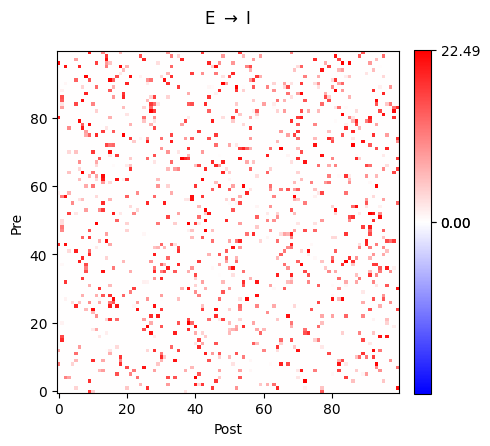

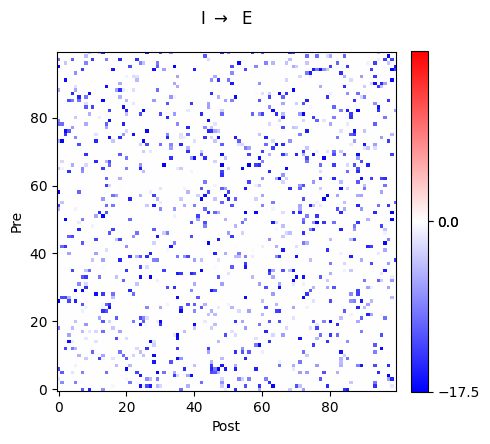

In [32]:
# Run with Poisson spikes into the Input layer 
net.run(inputs={"Input": I_ext}, time=T)

w_exc_inh = net.connections[('Exc','Inh')].w
w_inh_exc = net.connections[('Inh','Exc')].w


plot_connectivity(w_exc_inh,  title=r"E $\rightarrow$ I")
plot_connectivity(w_inh_exc,  title=r"I $\rightarrow$  E")

## Diehl Cook

In [34]:
from bindsnet.models import DiehlAndCook2015

net = DiehlAndCook2015(
    n_inpt=784,
    n_neurons=n_neurons,
    exc=exc,
    inh=inh,
    dt=dt,
    nu = [0.0001, 0.01], 
    norm=78.4,
    theta_plus=theta_plus,
    inpt_shape=(1, 28, 28),
)


In [35]:
net.connections


{('X',
  'Ae'): Connection(
   (source): Input()
   (target): DiehlAndCookNodes()
 ),
 ('Ae',
  'Ai'): Connection(
   (source): DiehlAndCookNodes()
   (target): LIFNodes()
 ),
 ('Ai',
  'Ae'): Connection(
   (source): LIFNodes()
   (target): DiehlAndCookNodes()
 )}

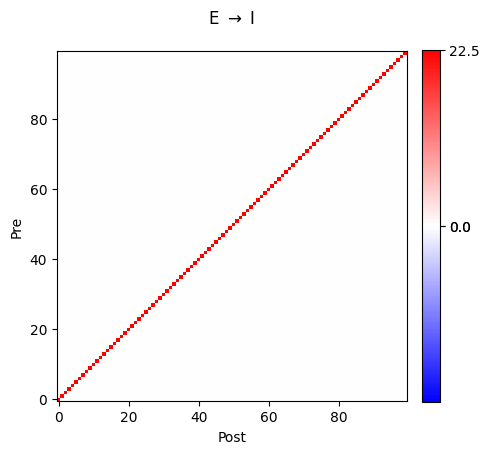

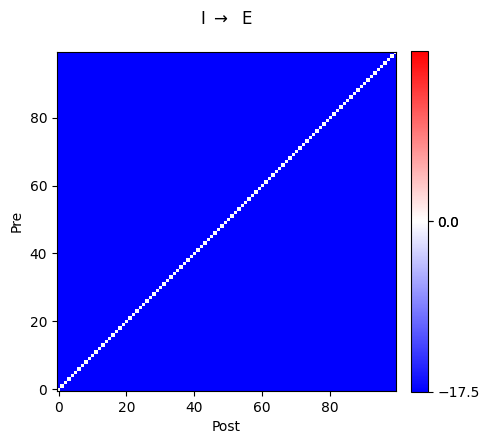

In [36]:
# Run with Poisson spikes into the Input layer 
net.run(inputs={"Input": I_ext}, time=T)

w_exc_inh = net.connections[('Ae','Ai')].w
w_inh_exc = net.connections[('Ai','Ae')].w

plot_connectivity(w_exc_inh,  title=r"E $\rightarrow$ I")
plot_connectivity(w_inh_exc,  title=r"I $\rightarrow$  E")

### Training


In [ ]:
epochs = 10

for epoch in range(epochs):
    #I_ext = torch.from_numpy(I_ext)
    net.reset_state_variables()
        
    # Run the simulation
    net.run(inputs={"Input": I_ext}, time=T, train=True )

        

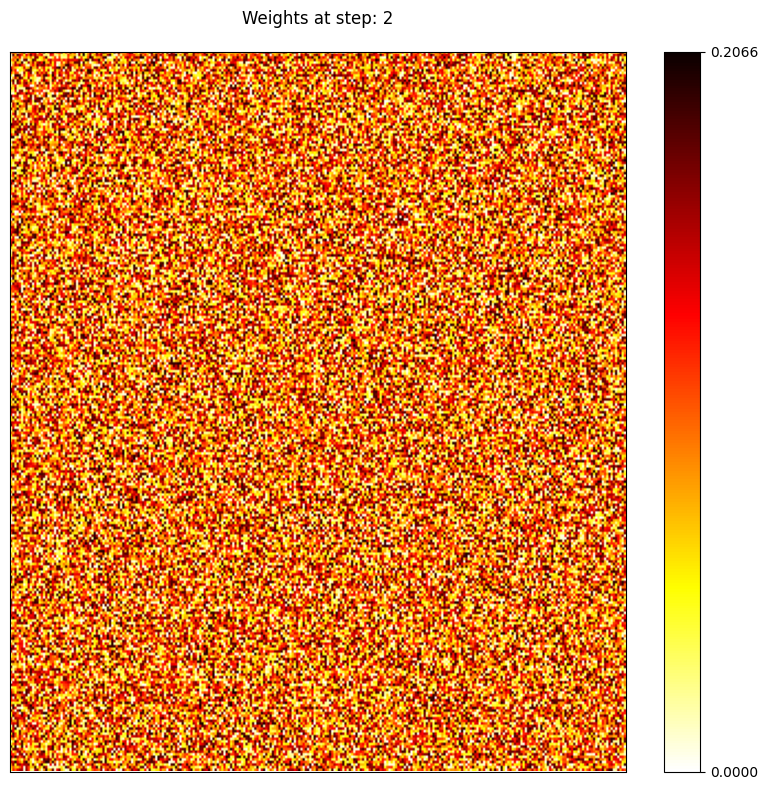

In [ ]:
w_x_exc = net.connections[('X', 'Ae')].w

draw_weights(w_x_exc, 1)
#plot_connectivity(w_x_exc,  title="w_x_exc")

## Love thy neighbors

In [40]:
def connect_distance(n_neurons, _, sigma=3.0, p_max=0.7, circular=False, exclude_self=True):
    """
    Distance-dependent binary connectivity (1D).
    - Neurons are placed on a 1D line with indices 0..n-1.
    - Connection prob decays with distance: p_ij = p_max * exp(-(d_ij^2)/(2*sigma^2))
    - If circular=True, distance wraps around (ring topology).

    Computes:
        A   : [n, n] binary adjacency (0/1)
        P   : [n, n] connection probabilities used
        D   : [n, n] pairwise distances
        
    Returns:
        A   : [n, n] binary adjacency (0/1)
    """
    idx = np.arange(n_neurons)
    D = np.abs(idx[:, None] - idx[None, :])  # |i-j|
    if circular:
        D = np.minimum(D, n_neurons - D)     # wrap-around distance on a ring

    # Pprobabilities decay exponentially with distance
    P = p_max * np.exp(-(D**2) / (10 * sigma**2))

    # Sample connections
    A = (np.random.rand(n_neurons, n_neurons) < P).astype(np.float32)

    if exclude_self:
        np.fill_diagonal(A, 0)
        A[np.diag_indices(n_neurons)] = 0.0

    return A

In [41]:
from bindsnet.models import IncreasingInhibitionNetwork
from bindsnet.network.nodes import DiehlAndCookNodes, Input, LIFNodes
from scipy.spatial.distance import euclidean



input_layer = Input(
    n=n_inpt, shape=inpt_shape, traces=True, tc_trace=20.0
)

exc_layer = LIFNodes(
    n=n_neurons,
    traces=True,
    rest=-65.0,
    reset=-60.0,
    thresh=exc_thresh,
    refrac=5,
    tc_decay=100.0,
    tc_trace=20.0,
    theta_plus=theta_plus,
    tc_theta_decay=tc_theta_decay,
)

inh_layer = LIFNodes(
    n=n_neurons,
    traces=False,
    rest=-60.0,
    reset=-45.0,
    thresh=inh_thresh,
    tc_decay=10.0,
    refrac=2,
    tc_trace=20.0,
)


# Connections
# I -> Ex
connections = connect_all_to_all(n_inpt, n_neurons)
weights     = np.random.rand(n_inpt, n_neurons).astype(np.float32)  
w           = exc * torch.from_numpy(connections * weights)
input_exc_conn = Connection(
    source=input_layer,
    target=exc_layer,
    w=w,
    update_rule=PostPre, # stdp
    nu=nu,
    reduction=reduction,
    wmin=wmin,
    wmax=wmax,
    norm=norm,
)

# Ex -> Inh
connections = connect_one_to_one(n_neurons, n_neurons)
weights     = np.random.rand(n_neurons, n_neurons).astype(np.float32)  
w           = exc * torch.from_numpy(connections * weights)
exc_inh_conn = Connection(
    source=exc_layer, target=inh_layer, w=w, wmin=0, wmax=exc
)

# Inh -> Ex
connections1 = connect_all_to_all(n_neurons, n_neurons)
connections2 = connect_distance(n_neurons, n_neurons)
weights     = np.random.rand(n_neurons, n_neurons).astype(np.float32)  
w           = -inh * torch.from_numpy((connections1-connections2) * weights)

inh_exc_conn = Connection(
    source=inh_layer, target=exc_layer, w=w, wmin=-inh, wmax=0
)



# Add to network
net = Network()

net.add_layer(input_layer, name="X")
net.add_layer(exc_layer, name="Exc")
net.add_layer(inh_layer, name="Inh")
net.add_connection(input_exc_conn, source="X", target="Exc")
net.add_connection(exc_inh_conn, source="Exc", target="Inh")
net.add_connection(inh_exc_conn, source="Inh", target="Exc")




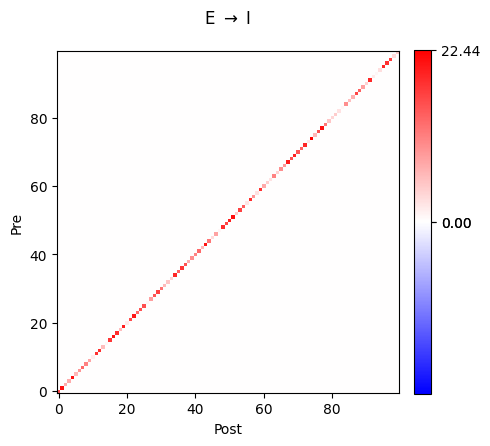

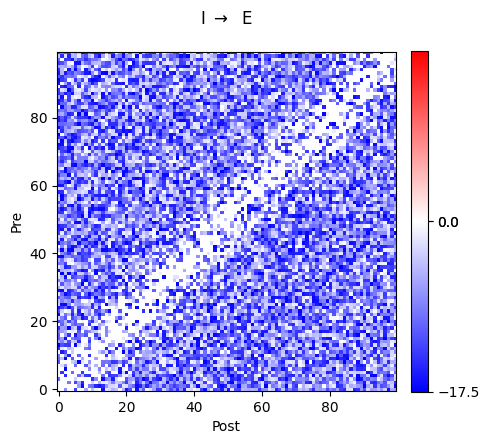

In [43]:
# Run with Poisson spikes into the Input layer 
net.run(inputs={"Input": I_ext}, time=T)

w_exc_inh = net.connections[('Exc','Inh')].w
w_inh_exc = net.connections[('Inh','Exc')].w



plot_connectivity(w_exc_inh,  title=r"E $\rightarrow$ I")
plot_connectivity(w_inh_exc,  title=r"I $\rightarrow$  E")

## Diehl Cook with distance increasing inhib
from https://arxiv.org/pdf/1807.09374
note: bindsnet has an option for this model avaiable (IncreasingInhibitionNetwork) however, their implementation only has two layers, not three

In [44]:
from bindsnet.models import IncreasingInhibitionNetwork
from bindsnet.network.nodes import DiehlAndCookNodes, Input, LIFNodes
from scipy.spatial.distance import euclidean



input_layer = Input(
    n=n_inpt, shape=inpt_shape, traces=True, tc_trace=20.0
)

exc_layer = LIFNodes(
    n=n_neurons,
    traces=True,
    rest=-65.0,
    reset=-60.0,
    thresh=exc_thresh,
    refrac=5,
    tc_decay=100.0,
    tc_trace=20.0,
    theta_plus=theta_plus,
    tc_theta_decay=tc_theta_decay,
)

inh_layer = DiehlAndCookNodes(
    n=n_neurons,
    traces=False,
    rest=-60.0,
    reset=-45.0,
    thresh=inh_thresh,
    tc_decay=10.0,
    refrac=2,
    tc_trace=20.0,
)


# Connections
# I -> Ex
connections = connect_all_to_all(n_inpt, n_neurons)
weights     = np.random.rand(n_inpt, n_neurons).astype(np.float32)  
w           = exc * torch.from_numpy(connections * weights)
input_exc_conn = Connection(
    source=input_layer,
    target=exc_layer,
    w=w,
    update_rule=PostPre, # stdp
    nu=nu,
    reduction=reduction,
    wmin=wmin,
    wmax=wmax,
    norm=norm,
)

# Ex -> Inh
connections = connect_one_to_one(n_neurons, n_neurons)
weights     = np.random.rand(n_neurons, n_neurons).astype(np.float32)  
w           = exc * torch.from_numpy(connections * weights)
exc_inh_conn = Connection(
    source=exc_layer, target=inh_layer, w=w, wmin=0, wmax=exc
)

# Inh -> Ex
idx = np.arange(n_neurons)
D = torch.from_numpy(np.abs(idx[:, None] - idx[None, :]))  # |i-j|
w           =   D/ torch.max(D)
w *= - inh
inh_exc_conn = Connection(
            source=inh_layer, target=exc_layer, w=w,
        )




# Add to network
net = Network()

net.add_layer(input_layer, name="X")
net.add_layer(exc_layer, name="Exc")
net.add_layer(inh_layer, name="Inh")
net.add_connection(input_exc_conn, source="X", target="Exc")
net.add_connection(exc_inh_conn, source="Exc", target="Inh")
net.add_connection(inh_exc_conn, source="Inh", target="Exc")




In [45]:
net.connections

{('X',
  'Exc'): Connection(
   (source): Input()
   (target): LIFNodes()
 ),
 ('Exc',
  'Inh'): Connection(
   (source): LIFNodes()
   (target): DiehlAndCookNodes()
 ),
 ('Inh',
  'Exc'): Connection(
   (source): DiehlAndCookNodes()
   (target): LIFNodes()
 )}

In [46]:
w_inh_exc = net.connections[('Inh','Exc')].w
w_inh_exc

Parameter containing:
tensor([[ -0.0000,  -0.1768,  -0.3535,  ..., -17.1465, -17.3232, -17.5000],
        [ -0.1768,  -0.0000,  -0.1768,  ..., -16.9697, -17.1465, -17.3232],
        [ -0.3535,  -0.1768,  -0.0000,  ..., -16.7929, -16.9697, -17.1465],
        ...,
        [-17.1465, -16.9697, -16.7929,  ...,  -0.0000,  -0.1768,  -0.3535],
        [-17.3232, -17.1465, -16.9697,  ...,  -0.1768,  -0.0000,  -0.1768],
        [-17.5000, -17.3232, -17.1465,  ...,  -0.3535,  -0.1768,  -0.0000]])

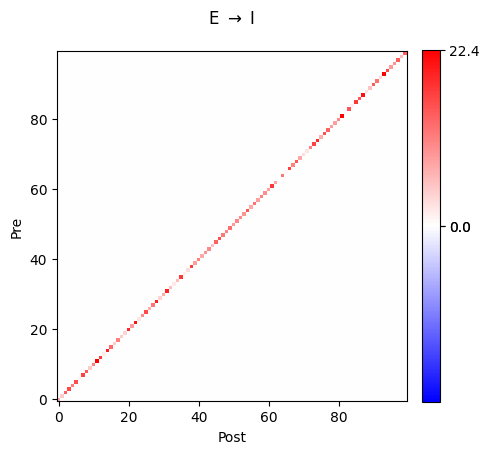

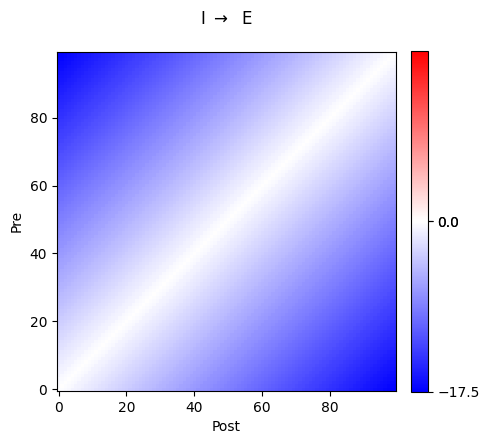

In [47]:
# Run with Poisson spikes into the Input layer 
net.run(inputs={"Input": I_ext}, time=T)

w_exc_inh = net.connections[('Exc','Inh')].w
w_inh_exc = net.connections[('Inh','Exc')].w

  
plot_connectivity(w_exc_inh,  title=r"E $\rightarrow$ I")
plot_connectivity(w_inh_exc,  title=r"I $\rightarrow$  E")